In [43]:
import numpy as np
import matplotlib.pyplot as plt

# import lumicks
import lumicks.pylake as lk

# %matplotlib inline
from skimage.transform import rescale
import tifffile
import os
from cv2 import warpAffine, invertAffineTransform
from pathlib import Path
from cv2 import estimateAffine2D, estimateAffinePartial2D
from picasso import io, postprocess
import json
from json import JSONEncoder
import argparse
import itertools
import math
import subprocess


def norm_image(image, inverse=False):
    amin = image.min()
    amax = image.max()

    if amax != amin:
        if inverse:
            return 1 - (image - amin) / (amax - amin)
        else:
            return (image - amin) / (amax - amin)
    else:
        return image


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [48]:
# Just to test without arguments


# irm_path = "data/20231228-A_IRM_0.5_beads.tif" #Reference for calculation
# wt_path =   "data/20231228-A_WT_0.5_beads.tif"


irm_path = "data/Arvind/Arvind_SARS1_VLP/20240918-112853_IRM.tiff"  # Test images
wt_path = "data/Arvind/Arvind_SARS1_VLP/20240918-112853_WT.tiff"
bright_path = (
    "video_alignment_data/20240716_Jurkat_20gs_myc/20240716-112826_Bright-field.tif"
)

output_path = "arvind_test/"


align_brightfield = False

bf_transform_matrix_file = "bf_transform_matrix.json"
transform_matrix_file = "transform_matrix.json"
use_existing_matrix = True  # always

In [49]:
# Check if the directory already exists
os.makedirs(output_path, exist_ok=True)

In [50]:
irm = lk.ImageStack(irm_path)  # Loading a stack.
wt = lk.ImageStack(wt_path)  # Loading a stack.

if align_brightfield:
    bright_file = lk.ImageStack(bright_path)
    bright_g_video = bright_file.get_image(channel="green")
    bright_g = bright_g_video[0]
    bright_metadata = bright_file._tiff_image_metadata()

wt.export_tiff(
    output_path + Path(wt_path).stem + "_aligned.tif"
)  # Save aligned wt stack

(682, 2048)


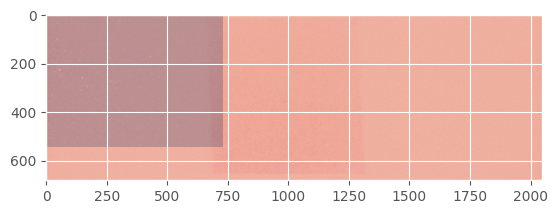

In [51]:
# Get channels
wt_g_video = wt.get_image(channel="green")
irm_g_video = irm.get_image()
# wt_r_video = wt.get_image(channel="red")
# wt_b_video = wt.get_image(channel="blue")

wt_g = wt_g_video[0]
irm_g = irm_g_video[0]

print(wt_g.shape)
plt.imshow(irm_g, alpha=0.5, cmap="Blues")
plt.imshow(wt_g, alpha=0.5, cmap="Reds")
# plt.imshow(bright_g, alpha=0.5, cmap="Greens")

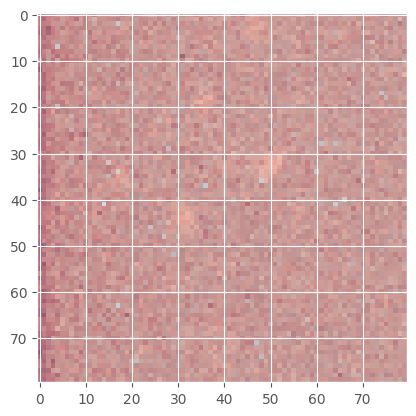

In [52]:
plt.imshow(irm_g[0:80, 0:80], alpha=0.5, cmap="Blues")
plt.imshow(wt_g[0:80, 0:80], alpha=0.5, cmap="Reds")

In [53]:
# Get metadata

wt_metadata = wt._tiff_image_metadata()
wt_framerate = wt_metadata["Framerate (Hz)"]
wt_roi = wt_metadata["Region of interest (x, y, width, height)"]
wt_frame_averaging = wt_metadata["Frame averaging"]
print(wt_framerate)

irm_metadata = irm._tiff_image_metadata()
irm_roi = irm_metadata[
    "Region of interest (x, y, width, height)"
]  # This is different because the wt was prexviously aligned I think. Can this cause issues?
irm_framerate = irm_metadata["Framerate (Hz)"]
irm_frame_averaging = irm_metadata["Frame averaging"]
print(irm_framerate)

if align_brightfield:
    bright_roi = bright_metadata[
        "Region of interest (x, y, width, height)"
    ]  # This is different because the wt was prexviously aligned I think. Can this cause issues?
    bf_framerate = bright_metadata["Framerate (Hz)"]
    bf_frame_averaging = bright_metadata["Frame averaging"]
    print(bright_roi)

1.3463096038187803
100.03201024327785


In [30]:
print(wt_roi)

[0, 0, 2048, 682]


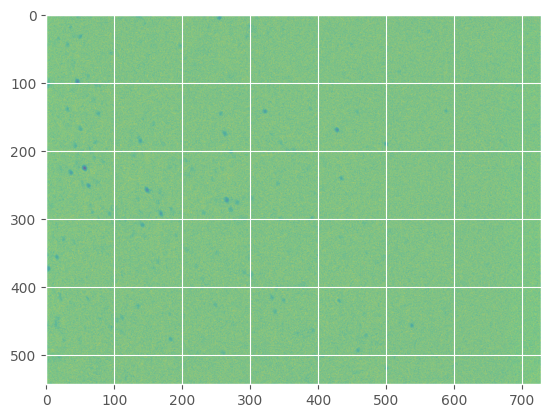

In [54]:
fig, ax1 = plt.subplots()


# Pad both images to region of interest
padded_wt_filename = Path(wt_path).stem + "_padded.tif"
wt_g_padded = np.pad(wt_g, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)])
# wt_g_padded = wt_g
tifffile.imwrite(output_path + padded_wt_filename, wt_g_padded)

padded_irm_filename = Path(irm_path).stem + "_padded.tif"
irm_g_padded = np.pad(irm_g, [(int(irm_roi[1]), 0), (int(irm_roi[0]), 0)])
# irm_g_padded = irm_g
tifffile.imwrite(output_path + padded_irm_filename, irm_g_padded)

if align_brightfield:
    padded_bright_filename = Path(bright_path).stem + "_padded.tif"
    bright_g_padded = np.pad(
        bright_g, [(int(bright_roi[1]), 0), (int(bright_roi[0]), 0)]
    )

    # irm_g_padded = irm_g

    # irm_g_padded = np.pad(irm_g, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])

    # irm_g_padded = np.pad(irm_g_padded, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])

    tifffile.imwrite(output_path + padded_bright_filename, bright_g_padded)


# plt.imshow(bright_g_padded, alpha=0.5)


ax1.imshow(wt_g_padded, alpha=0.5)
# ax1.set_xlim(wt_roi[0], wt_roi[0] + wt_roi[2])
# ax1.set_ylim(wt_roi[1], wt_roi[1] + wt_roi[3])

ax1.imshow(irm_g_padded, alpha=0.5)
# ax1.set_xlim(irm_roi[0], irm_roi[0] + irm_roi[2])
# ax1.set_ylim(irm_roi[1], irm_roi[1] + irm_roi[3])


# ax1.imshow(bright_g_padded, alpha=0.5)
# ax1.set_xlim(bright_roi[0], bright_roi[0] + bright_roi[2])
# ax1.set_ylim(bright_roi[1], bright_roi[1] + bright_roi[3])

In [32]:
"""wt_g_video_padded = np.array(
    [np.pad(frame, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)]) for frame in wt_g_video]
)


wt_r_video_padded = np.array(
    [np.pad(frame, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)]) for frame in wt_r_video]
)
wt_b_video_padded = np.array(
    [np.pad(frame, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)]) for frame in wt_b_video]
)

irm_video_padded = np.array(
    [
        np.pad(frame, [(int(irm_roi[1]), 0), (int(irm_roi[0]), 0)])
        for frame in irm_g_video
    ]
)

if align_brightfield:
    bf_video_padded = np.array(
        [
            np.pad(frame, [(int(bf_roi[1]), 0), (int(bf_roi[0]), 0)])
            for frame in bf_video
        ]
    )
"""

'wt_g_video_padded = np.array(\n    [np.pad(frame, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)]) for frame in wt_g_video]\n)\n\n\nwt_r_video_padded = np.array(\n    [np.pad(frame, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)]) for frame in wt_r_video]\n)\nwt_b_video_padded = np.array(\n    [np.pad(frame, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)]) for frame in wt_b_video]\n)\n\nirm_video_padded = np.array(\n    [\n        np.pad(frame, [(int(irm_roi[1]), 0), (int(irm_roi[0]), 0)])\n        for frame in irm_g_video\n    ]\n)\n\nif align_brightfield:\n    bf_video_padded = np.array(\n        [\n            np.pad(frame, [(int(bf_roi[1]), 0), (int(bf_roi[0]), 0)])\n            for frame in bf_video\n        ]\n    )\n'

In [55]:
transform_mat = []  # set to empty to check afterwards if I have a matrix
bf_transform_mat = []


if use_existing_matrix:  # If I have provided a matrix, use that
    with open(transform_matrix_file, "r") as read_file:
        decodedArray = json.load(read_file)
        transform_mat = np.asarray(decodedArray["transform_matrix"])
        rmsd = decodedArray["rmsd"]
        print(transform_mat)
    if align_brightfield:
        with open(bf_transform_matrix_file, "r") as read_file:
            decodedArray = json.load(read_file)
            bf_transform_mat = np.asarray(decodedArray["transform_matrix"])
            print(bf_transform_mat)
            rmsd = decodedArray["rmsd"]

# manual_x_offset = 327
# manual_y_offset = 230

# bf_transform_mat[0][2] = bf_transform_mat[0][2] + manual_x_offset
# bf_transform_mat[1][2] = bf_transform_mat[1][2] + manual_y_offset
# print(bf_transform_mat)

[[ 1.05330267e+00  3.02047107e-02  6.95653078e+02]
 [-2.48180192e-02  1.05867467e+00  8.02749179e+01]]


In [57]:
# print(irm_framerate)

ignore_framerate = True  # this is for the weird arvind files. Usually False


if not ignore_framerate:
    real_irm_framerate = irm_framerate / irm_frame_averaging
    if align_brightfield:
        real_bf_framerate = bf_framerate / bf_frame_averaging
    real_wt_framerate = wt_framerate / wt_frame_averaging
else:
    real_wt_framerate = wt_framerate / wt_frame_averaging
    real_irm_framerate = real_wt_framerate

# print(real_irm_framerate)
# print(real_wt_framerate)

print(len(irm_g_video))
print(len(wt_g_video))
# print(real_wt_framerate)
# print(real_irm_framerate)
# print(wt_frame_averaging)
# print(irm_frame_averaging)

for frame_n, frame in enumerate(wt_g_video):

    # irm_g_padded_asd = irm_g_video[
    #    round(frame_n * real_irm_framerate / real_wt_framerate)
    # ]
    print(round(frame_n * real_irm_framerate / real_wt_framerate))
    print("")

9
9
0

1

2

3

4

5

6

7

8



In [58]:
irm_warped_video = []
bf_warped_video = []
wt_video = []


if len(transform_mat != 0):  # If I have a matrix either from file or calculated

    for frame_n, frame in enumerate(wt_g_video):

        irm_g_padded = np.pad(
            irm_g_video[round(frame_n * real_irm_framerate / real_wt_framerate)],
            [(int(irm_roi[1]), 0), (int(irm_roi[0]), 0)],
        )

        wt_g_padded = np.pad(frame, [(int(wt_roi[1]), 0), (int(wt_roi[0]), 0)])
        """

        irm_g_padded = irm_video_padded[
            round(frame_n * real_irm_framerate / real_wt_framerate)
        ]

        wt_g_padded = frame
        """
        irm_g_padded_warped = warpAffine(
            irm_g_padded, transform_mat, (wt_g_padded.shape[1], wt_g_padded.shape[0])
        )

        # This hack is done to reduce the total contrast in the resulting image

        # Otherwise, the 0s make it hard to see

        irm_g_padded_warped[irm_g_padded_warped <= np.amin(irm_g_padded)] = np.mean(
            irm_g_padded
        )

        irm_g_padded_warped = norm_image(irm_g_padded_warped, False)

        wt_g_padded = norm_image(wt_g_padded)

        wt_video.append(wt_g_padded)

        irm_warped_video.append(irm_g_padded_warped)

        if align_brightfield:
            if len(bf_transform_mat) != 0:
                bf_g_padded = bright_g_video[
                    round(frame_n * real_bf_framerate / real_wt_framerate)
                ]

                bf_g_padded_warped = warpAffine(
                    bf_g_padded,
                    bf_transform_mat,
                    (wt_g_padded.shape[1], wt_g_padded.shape[0]),
                )

                # This hack is done to reduce the total contrast in the resulting image
                # Otherwise, the 0s make it hard to see

                bf_g_padded_warped[bf_g_padded_warped <= np.amin(bf_g_padded)] = (
                    np.mean(bf_g_padded)
                )

                bf_g_padded_warped = norm_image(bf_g_padded_warped, False)
                bf_warped_video.append(bf_g_padded_warped)

        # tifffile.imwrite(
        # output_path + Path(irm_path).stem + f"_aligned_{frame_n}.tif",
        # irm_g_padded_warped_cropped,

        # metadata=irm_metadata,

        # )  # save irm image without the padding
        # plt.imshow(irm_g_padded, alpha=0.5)
        # plt.imshow(bf_g_padded_warped, alpha=0.5, cmap="Blues")

    if align_brightfield:
        stacked_video = np.stack(
            [wt_video, irm_warped_video, bf_warped_video], axis=1
        )  # Save stacked g and irm image

    else:

        stacked_video = np.stack(
            [wt_video, irm_warped_video], axis=1
        )  # Save stacked g and irm image

    tifffile.imwrite(
        output_path + Path(wt_path).stem + "_multichannel_aligned.tif",
        np.float32(stacked_video),
        imagej=True,
        metadata={
            "Composite mode": "composite",  # This is what was needed for fiji to open it merged
        },
    )

    # plt.imshow(wt_g)

    # delete padded files

    # os.remove(output_path + padded_irm_filename)

    # os.remove(output_path + padded_wt_filename)